In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df_features = pd.read_csv(r"1.1-Output/ProcessedFeatures.csv")
df_labels = pd.read_csv(r"1.0-Output/AllDaysCombinedLabels.csv")
df_attempted = pd.read_csv(r"1.0-Output/AllDaysCombinedAttemptedBool.csv")

In [10]:
df_labels.loc[df_attempted['Attempted Category'] != -1, 'Label'] = 'BENIGN'

In [12]:
df_features.drop(columns=['ICMP Code', 'ICMP Type', 'Src Port', 'Dst Port', 'Protocol', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count'], inplace=True)

In [13]:
# Combine into a single DataFrame
df = df_features.copy()
df['Label'] = df_labels.iloc[:, 0]  # Add target column

In [16]:
# Encode the categorical target into numeric (required for Pearson correlation)
df['Label'] = df['Label'].astype('category').cat.codes

In [18]:
correlation_matrix_full = df.corr().abs()
corr_with_target = correlation_matrix_full['Label'].drop('Label')
correlation_matrix = df_features.corr().abs()

In [38]:
def greedy_forward_selection(corr_matrix, corr_with_target, tolerance=1e-3):
    """
    Performs correlation-based Greedy Forward Selection.

    Parameters:
    -----------
    corr_matrix : pd.DataFrame
        Pairwise correlation matrix of features.
    corr_with_target : pd.Series
        Correlation of each feature with the target label.
    tolerance : float
        Minimum improvement in merit required to continue selection.

    Returns:
    --------
    selected_features : list
        Ordered list of selected features.
    avg_corr : float
        Average pairwise correlation of selected features.
    """
    remaining_features = list(corr_with_target.index)
    selected_features = []
    prev_best_merit = 0

    while remaining_features:
        best_merit = -1
        best_feature = None

        for feature in remaining_features:
            k = len(selected_features) + 1

            # Relevance with target
            r_cf = (sum(corr_with_target[f] for f in selected_features) + corr_with_target[feature]) / k

            # Redundancy with selected
            if len(selected_features) == 0:
                r_ff = 0
            else:
                temp_set = selected_features + [feature]
                r_vals = [
                    corr_matrix.loc[temp_set[i], temp_set[j]]
                    for i in range(len(temp_set))
                    for j in range(i + 1, len(temp_set))
                ]
                r_ff = np.mean(r_vals) if r_vals else 0

            # Merit Function
            merit = (k * r_cf) / np.sqrt(k + k * (k - 1) * r_ff) if r_ff < 1 else 0

            if merit > best_merit:
                best_merit = merit
                best_feature = feature

        if best_merit - prev_best_merit < tolerance:
            break

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        prev_best_merit = best_merit

    # Compute final average pairwise correlation of selected features
    if len(selected_features) > 1:
        selected_corr = corr_matrix.loc[selected_features, selected_features]
        avg_corr = selected_corr.where(
            np.triu(np.ones(selected_corr.shape), k=1).astype(bool)
        ).mean().mean()
    else:
        avg_corr = 0.0

    return selected_features, avg_corr


In [66]:
selected_features, avg_corr = greedy_forward_selection(
    correlation_matrix, 
    corr_with_target,
    tolerance=3.175e-4)

print(f"Selected Features ({(len(selected_features))}):\n{selected_features}")

print("\nAverage Correlation (after reduction):", avg_corr)

Selected Features (9):
['Fwd Seg Size Min', 'RST Flag Count', 'Bwd RST Flags', 'Packet Length Variance', 'Packet Length Min', 'Bwd Packets/s', 'Bwd Bulk Rate Avg', 'Bwd IAT Max', 'Fwd Packet Length Mean']

Average Correlation (after reduction): 0.21968943059781348


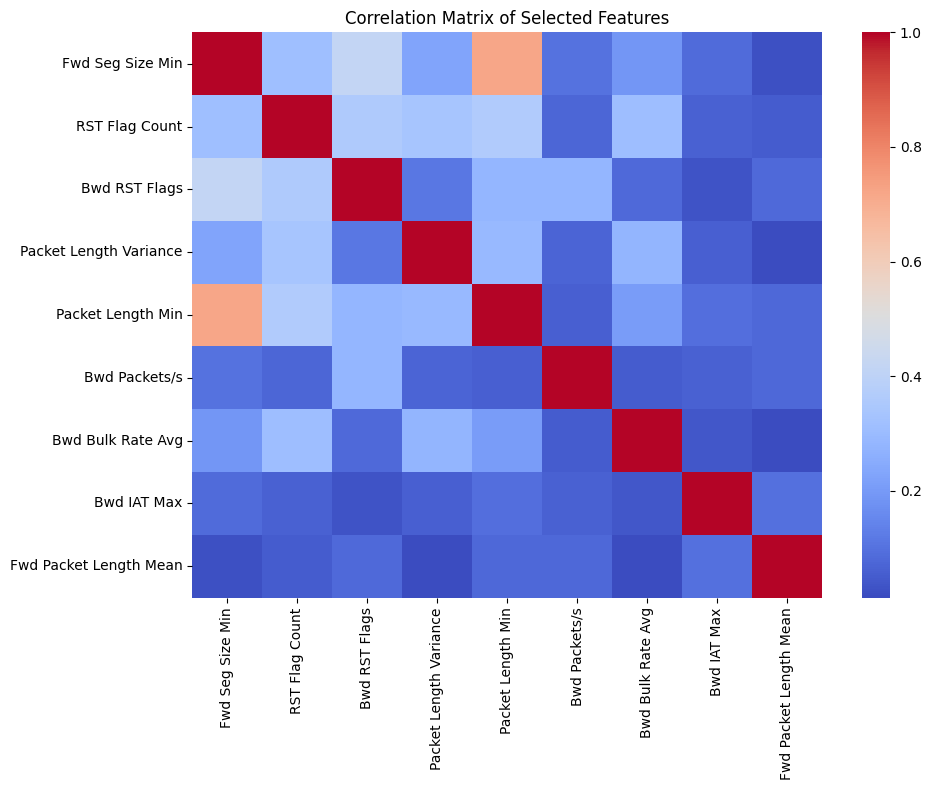

In [67]:
# Compute correlation matrix for selected features
selected_corr_matrix = df[selected_features].corr().abs()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Selected Features")
plt.tight_layout()
plt.show()

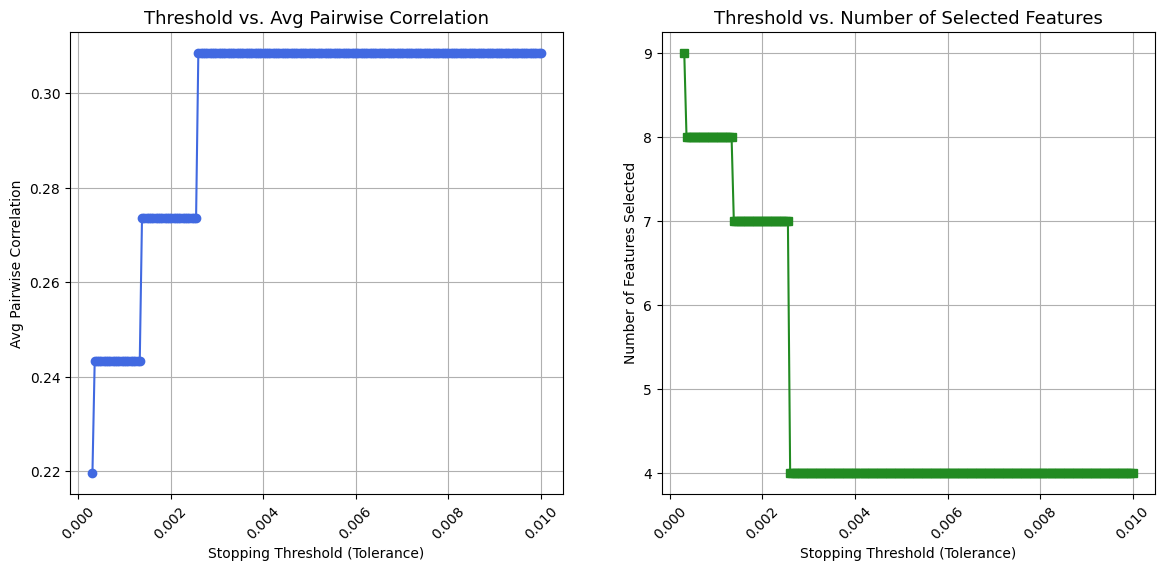

In [68]:
thresholds = np.linspace(3.1e-4, 1e-2, 200)
# thresholds = np.linspace(1e-4, 1e-2, 100)

avg_corrs = []
num_selected = []

for tol in thresholds:
    selected_feats, avg_corr = greedy_forward_selection(
        corr_matrix=correlation_matrix,
        corr_with_target=corr_with_target,
        tolerance=tol
    )
    avg_corrs.append(avg_corr)
    num_selected.append(len(selected_feats))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(thresholds, avg_corrs, marker='o', color='royalblue')
axes[0].set_title("Threshold vs. Avg Pairwise Correlation", fontsize=13)
axes[0].set_xlabel("Stopping Threshold (Tolerance)")
axes[0].set_ylabel("Avg Pairwise Correlation")
axes[0].grid(True)

axes[1].plot(thresholds, num_selected, marker='s', color='forestgreen')
axes[1].set_title("Threshold vs. Number of Selected Features", fontsize=13)
axes[1].set_xlabel("Stopping Threshold (Tolerance)")
axes[1].set_ylabel("Number of Features Selected")
axes[1].grid(True)

axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

plt.show()